In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

### **0. Vue d'ensemble**

In [2]:
import os
from pathlib import Path

data_folder = Path("../data")
os.listdir(data_folder)

['test_data.csv', 'example_submission.csv', 'train_data.csv']

In [3]:
data = pd.read_csv(data_folder / "train_data.csv")
data.head()

,ID,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,37765,15794860,Ch'eng,627,France,Male,28.0,7,131694.04,1,1.0,1.0,161205.61,0
1,130453,15728005,Hargreaves,597,France,Male,34.0,2,0.00,2,0.0,1.0,181419.29,0
2,77297,15686810,Ts'ui,724,France,Male,39.0,7,0.00,2,1.0,1.0,100862.54,0
3,40858,15760244,Trevisano,663,Germany,Female,56.0,5,118577.24,3,1.0,0.0,61164.45,1
4,19804,15810563,French,627,France,Female,33.0,5,0.00,2,1.0,1.0,103737.82,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143579 entries, 0 to 143578
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               143579 non-null  int64  
 1   CustomerId       143579 non-null  int64  
 2   Surname          143579 non-null  object 
 3   CreditScore      143579 non-null  int64  
 4   Geography        143579 non-null  object 
 5   Gender           143579 non-null  object 
 6   Age              143579 non-null  float64
 7   Tenure           143579 non-null  int64  
 8   Balance          143579 non-null  float64
 9   NumOfProducts    143579 non-null  int64  
 10  HasCrCard        143579 non-null  float64
 11  IsActiveMember   143579 non-null  float64
 12  EstimatedSalary  143579 non-null  float64
 13  Exited           143579 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 15.3+ MB


In [5]:
data.isna().sum()

ID                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
data.nunique()

ID                 143579
CustomerId          22017
Surname              2765
CreditScore           456
Geography               3
Gender                  2
Age                    71
Tenure                 11
Balance             27258
NumOfProducts           4
HasCrCard               2
IsActiveMember          2
EstimatedSalary     50076
Exited                  2
dtype: int64

- Ce jeu de données possède 143 579 lignes et 14 colonnes, toutes les valeurs étant renseignées
- Description des varibales ([source](https://www.kaggle.com/competitions/mlpro-classification-bank-churn/overview)) :
  - `ID` : L'identifiant unique de la ligne -> **ID**
  - `CustomerId` : Un identifiant unique pour chaque client (NB : Cette variable n'est pas unique pour chaque clients, s'agit-il d'une erreur ?)
  - `Surname` : Le nom de famille du client
  - `CreditScore` : Une valeur numérique représentant le score de crédit du client
  - `Geography` : Le pays où réside le client (France, Spain ou Germany)
  - `Gender` : Le genre du client (Male or Female)
  - `Age` : L'âge du client
  - `Tenure` : Le nombre d'années pendant lesquelles le client est avec la banque
  - `Balance` : Le solde du compte du client
  - `NumOfProducts` : Le nombre de produits bancaires utilisés par le client (par exemple, compte d'épargne, carte de crédit)
  - `HasCrCard` : Si le client possède une carte de crédit (1 = oui, 0 = non)
  - `IsActiveMember` : Si le client est un membre actif (1 = oui, 0 = non)
  - `EstimatedSalary` : Le salaire estimé du client
  - `Exited` : Si le client a résilié (1 = oui, 0 = non) -> **TARGET**

### **1. Analyse du dataset**

In [7]:
# Suppression des variables a priori inutiles
df = data.copy().sort_values("Exited")
df.drop(columns=["CustomerId", "Surname"], inplace=True)

In [8]:
# Conversion de certaines variables float en int
float_to_int_cols = ["HasCrCard", "IsActiveMember"]
df[float_to_int_cols] = df[float_to_int_cols].astype(int)

In [9]:
# Note (pas forcément utile) : 2 personnes ont des âges ayant des décimales
df[df["Age"].astype(int) != df["Age"]]

,ID,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
52867,48694,756,France,Male,36.44,1,134250.17,1,0,1,170041.95,0
114298,125279,619,Spain,Female,32.34,8,0.00,2,1,0,138555.46,0


In [10]:
df["Exited"] = df["Exited"].map({0: "Stayed", 1: "Exited"})

- Variables discrètes :
  - Geography
  - Gender
  - Tenure
  - NumOfProducts
  - HasCrCard
  - IsActiveMember
  - Exited
- Variables continues :
  - CreditScore
  - Age
  - Balance
  - EstimatedSalary

In [11]:
disc = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember"]
cont = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
target = "Exited"

#### **1.1. Analyse univariée** 

##### **a. Variables discrètes**

In [12]:
print(disc + [target])

['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']


In [13]:
def show_countplot(col, disc=disc, df=df, target=target, **kwargs):
    if col not in disc + [target]:
        print(f"La colonne '{col}' n'est pas une variable discrète.")
        return

    counts = df[col].value_counts()
    total = counts.sum()
    
    plt.figure(figsize=(6, 5))
    bars = plt.bar(counts.index, counts.values)
    plt.ylabel("Count")
    plt.title(kwargs.get("title", f"Nombre d'observations par {col}"))
    
    for bar in bars:
        height = bar.get_height()
        proportion = round(height / total, 2)
        
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + height / 2,
            f"{proportion:.0%}",
            ha="center",
            va="center",
            c="w",
            rotation=kwargs.get("text_rotation", "horizontal"),
        )

    if kwargs.get("xticks_as_int"):
        plt.xticks(ticks=counts.index.astype(int))

    plt.show()

---

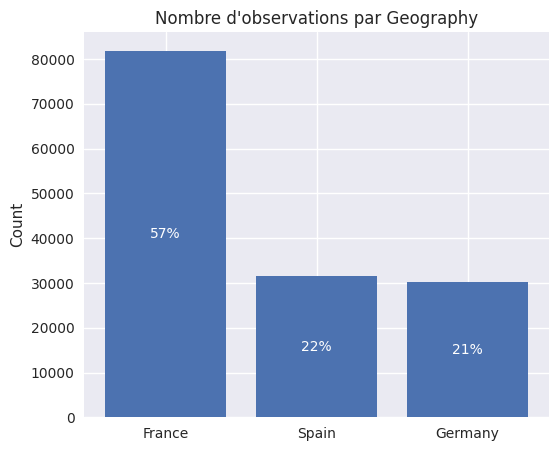

In [14]:
col = "Geography"
show_countplot(col)

- La base de données possède 3 fois plus de clients français que d'espagnols et d'allemands.

---

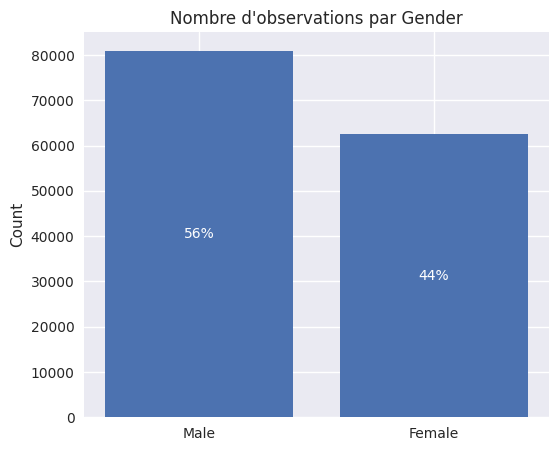

In [15]:
col = "Gender"
show_countplot(col)

- Nous avons à peu près 55% d'hommes et 45% de femmes, les classes sont équilibrées.

---

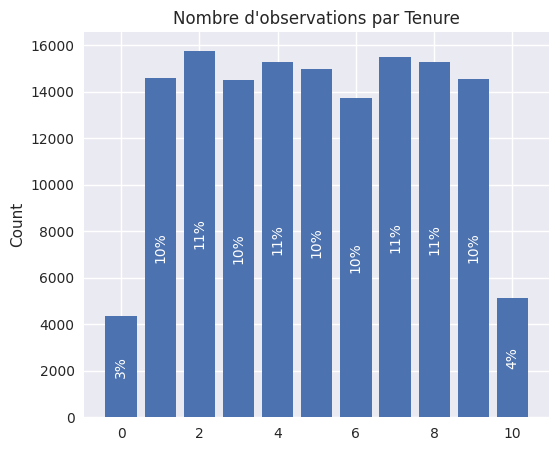

In [16]:
col = "Tenure"
show_countplot(col, text_rotation="vertical")

---

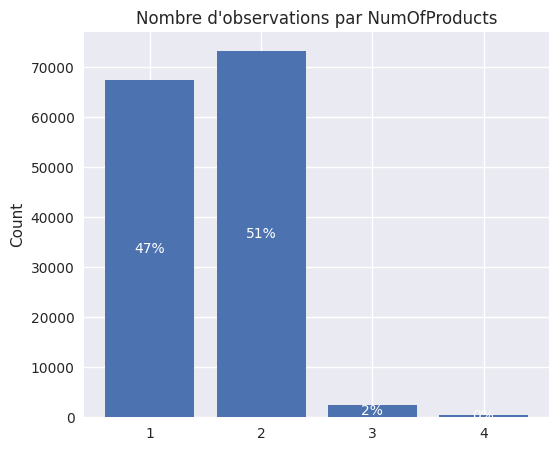

In [17]:
col = "NumOfProducts"
show_countplot(col, xticks_as_int=True)

- L'écrasante majorité des clients a souscrit à 1 ou 2 produits.

---

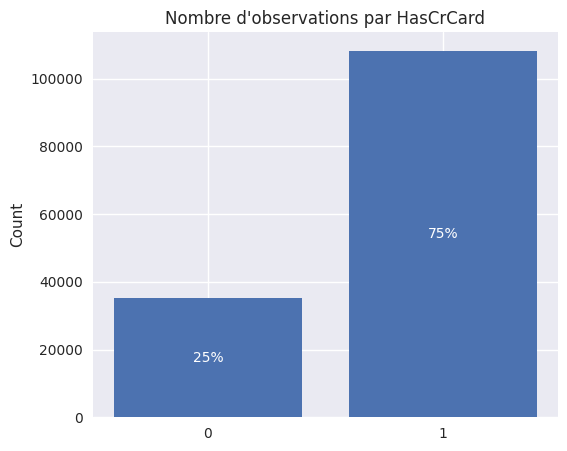

In [18]:
col = "HasCrCard"
show_countplot(col, xticks_as_int=True)

- Un quart des clients ne possède pas de carte bancaire.

---

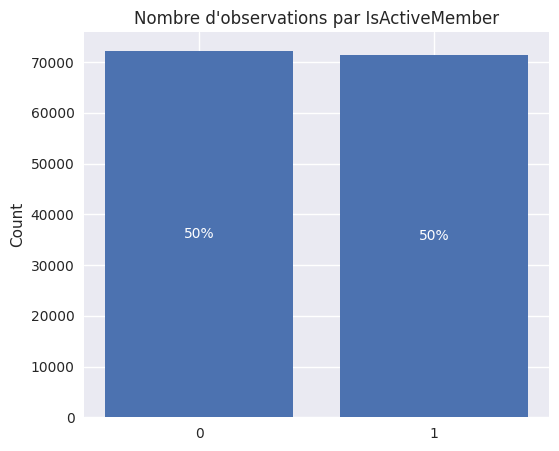

In [19]:
col = "IsActiveMember"
show_countplot(col, xticks_as_int=True)

- Les clients actifs et non actifs sont équitablement répartis dans ce jeu de données.

---

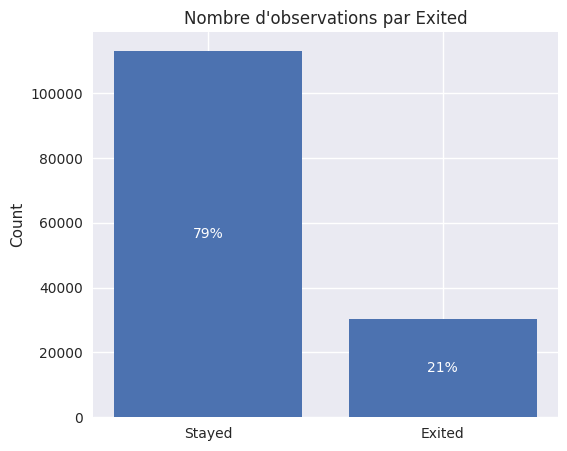

In [20]:
col = "Exited"  # cible
show_countplot(col)

- La taux de churn dans nos données est de 20%.

---

##### **b. Variables continues**

In [21]:
print(cont)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


In [22]:
def show_distribution(col, cont=cont, df=df, **kwargs):
    if col not in cont:
        print(f"La colonne '{col}' n'est pas une variable continue.")
        return
    
    data = df[col]
    
    fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, height_ratios=[1, 7])
    plt.subplots_adjust(hspace=0.02)

    # Boîte à moustaches
    axes[0].boxplot(
        data,
        sym=".",
        orientation="horizontal",
        widths=0.6,
        tick_labels=[""],
        patch_artist=True,
        medianprops={"color": "k"},
    )
    
    # Histogramme
    axes[1].hist(data, bins=100)
    axes[1].set_ylabel("Count")

    if "xticks" in kwargs:
        axes[1].set_xticks(kwargs["xticks"])
    
    fig.suptitle(kwargs.get("title", f"Distribution de {col}"))
    plt.show()

---

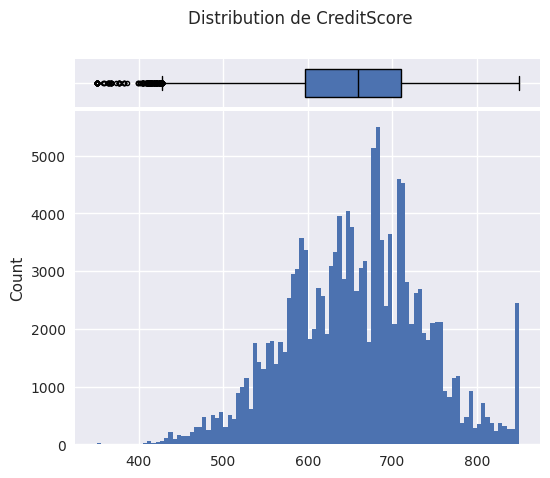

Tableau des statistiques


,CreditScore
count,143579.00
mean,656.41
std,80.21
min,350.00
25%,597.00
50%,659.00
75%,710.00
max,850.00


In [23]:
col = "CreditScore"
show_distribution(col)

print("Tableau des statistiques")
pd.DataFrame(df[col].describe().round(2))

- Cette distribution s'apparente à une loi normale avec un pic de clients ayant un score maximal, c'est-à-dire que la banque a une grande confiance en leur capacité de remboursement d'un crédit.

---

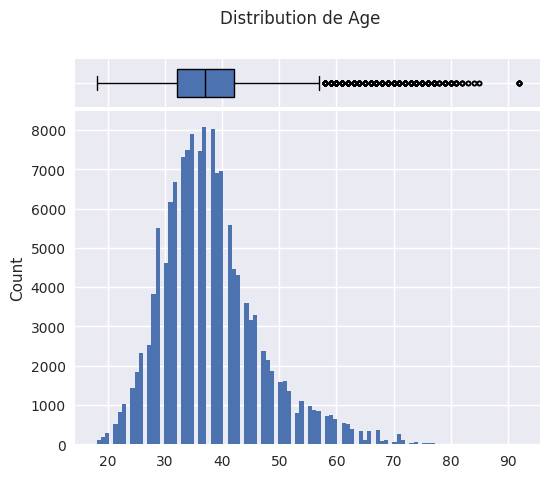

Tableau des statistiques


,Age
count,143579.00
mean,38.14
std,8.87
min,18.00
25%,32.00
50%,37.00
75%,42.00
max,92.00


In [24]:
col = "Age"
show_distribution(col)

print("Tableau des statistiques")
pd.DataFrame(df[col].describe().round(2))

- La moyenne d'âge se situe aux alentours de 38 ans, avec un écart-type d'environ 9 ans.
- La distribution est asymétrique, avec des valeurs qui s'étendent davantage à droite de la médiane. La boîte à moustache laisse apparaître de nombreux outliers (tranche 58-92 ans).

---

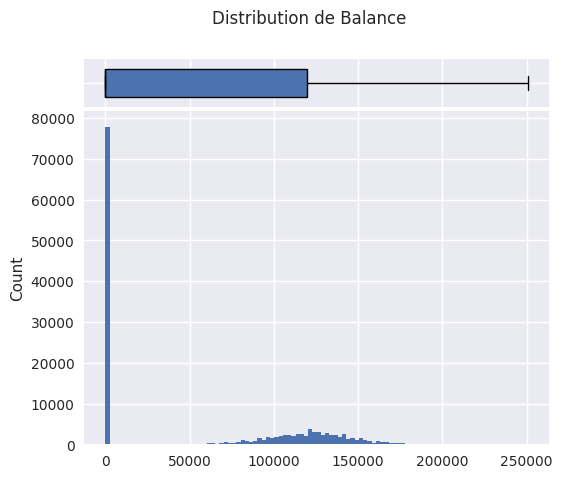

Tableau des statistiques


,Balance
count,143579.00
mean,55533.64
std,62822.62
min,0.00
25%,0.00
50%,0.00
75%,119948.09
max,250898.09


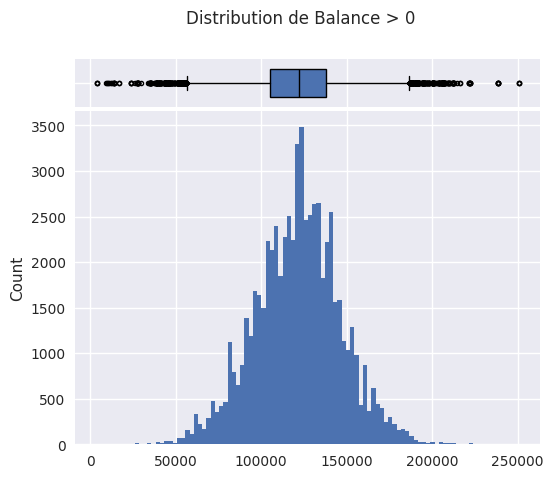

Tableau des statistiques


,Balance
count,65661.00
mean,121433.80
std,25050.67
min,3768.69
25%,105204.17
50%,122311.71
75%,137781.65
max,250898.09


In [25]:
col = "Balance"

show_distribution(col)
print("Tableau des statistiques")
display(pd.DataFrame(df[col].describe().round(2)))

show_distribution(
    col,
    df=df.query(f"{col} > 0"),
    title=f"Distribution de {col} > 0"
)
print("Tableau des statistiques")
display(pd.DataFrame(df.query(f"{col} > 0")[col].describe().round(2)))

In [26]:
print(f'Proportion de soldes non nuls : {len(df.query(f"{col} > 0")) / len(df):.2%}.')

Proportion de soldes non nuls : 45.73%.


- 55% des clients ont un solde nul.
- Le solde des 45% restants semble normalement distribué, avec une moyenne avoisinnant les 121K€ et un écart-type de 25K€.
- Dans ce 2e groupe, les soldes minimum et maximum sont respectivement de 3,7K€ et 250K€.
- On note enfin des outliers de part et d'autre de la médiane.

---

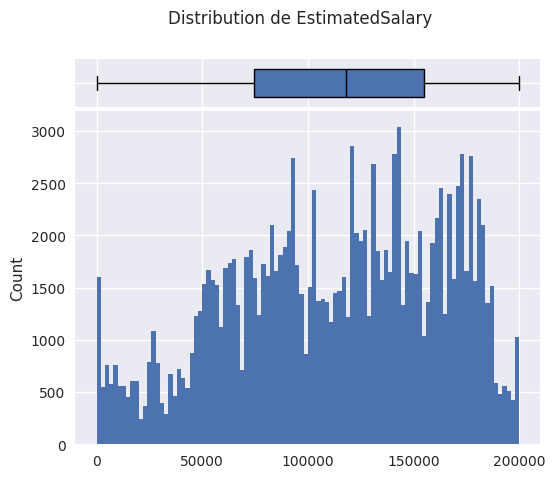

Tableau des statistiques


,EstimatedSalary
count,143579.00
mean,112530.07
std,50301.72
min,11.58
25%,74580.80
50%,117931.10
75%,155149.68
max,199992.48


In [27]:
col = "EstimatedSalary"
show_distribution(col, xticks=np.linspace(0, 2e5, 5))

print("Tableau des statistiques")
display(pd.DataFrame(df[col].describe().round(2)))

- Les salaires estimés vont de 11€ à 200K€, avec une moyenne de 112K€ et un écart-type de 50K€.

---

#### **1.2. Analyse multivariée**

##### **a. Variables discètes vs. cible (Exited)**

In [28]:
print(disc)

['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']


In [29]:
def analyze_disc_target(col, disc=disc, df=df, **kwargs):
    if col not in disc:
        print(f"La colonne '{col}' n'est pas une variable discrète.")
        return
    
    observed_norm = pd.crosstab(df[col], df[target], normalize="index").round(2)
    observed_norm = observed_norm[["Stayed", "Exited"]]
    
    colors = sns.color_palette()
    alpha = 0.8
    colors = [colors[1] + (alpha,), colors[2] + (alpha,)]
    
    _, ax = plt.subplots(figsize=(6, 5))
    bars = observed_norm.plot(kind="bar", stacked=True, color=colors, ax=ax)
    
    ax.set_title(kwargs.get("title", f"Pourcentage de résiliations par {col}"))
    ax.legend(bbox_to_anchor=(1.25, 1))
    
    for bar_container in bars.containers:
        for bar in bar_container:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.2f}", 
                ha="center",
                va="center",
                c="w",
                rotation=kwargs.get("text_rotation", "horizontal"),
            )
    
    plt.xticks(rotation=0)
    plt.show()

---

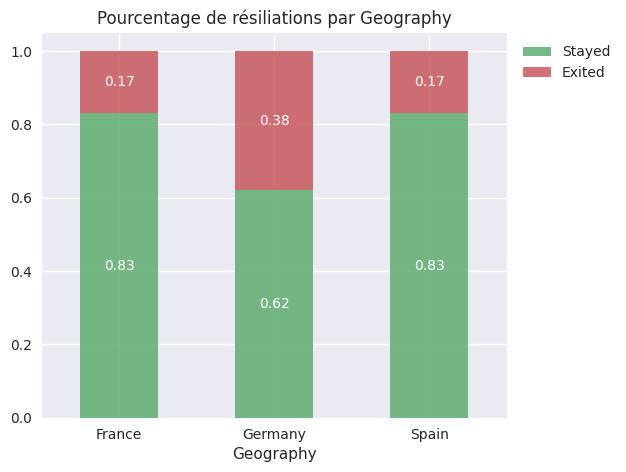

In [30]:
col = "Geography"
analyze_disc_target(col)

- Les clients allemands ont tendance à résilier plus souvent (38%) que les français et espagnols (17%).

---

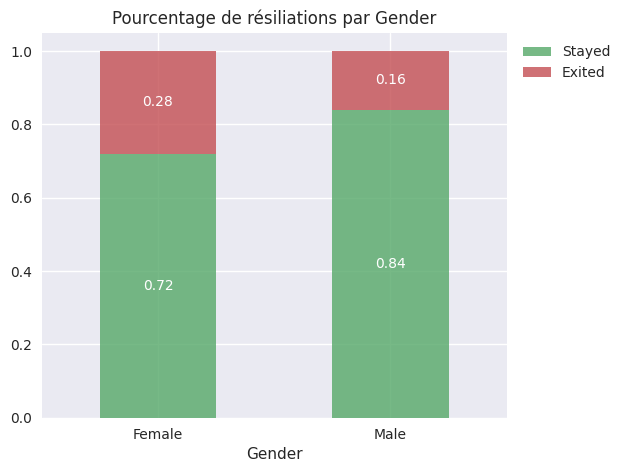

In [31]:
col = "Gender"
analyze_disc_target(col)

- Le taux de churn est plus élevé chez les femmes (28%) que chez les hommes (16%).

---

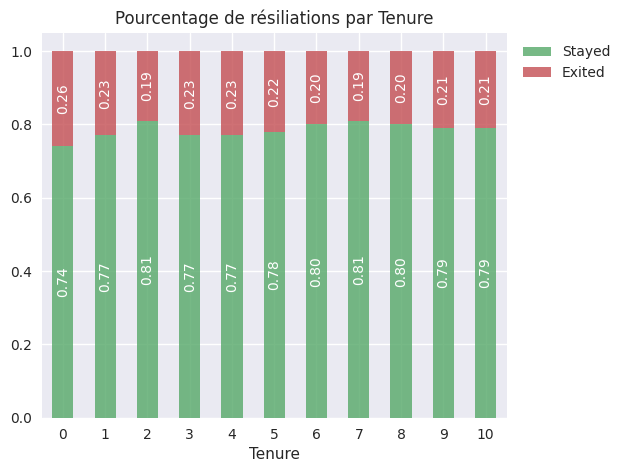

In [32]:
col = "Tenure"
analyze_disc_target(col, text_rotation="vertical")

- Aucune tendance particulière ne se dégage de la mise en relation entre la durée du contrat et la résiliation.
- Toutefois, le taux le plus élevé concerne ceux qui sont clients depuis moins d'un an (26%).

---

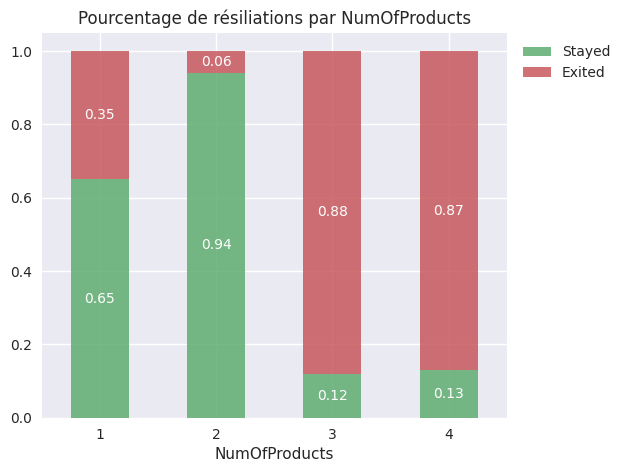

,NumOfProducts,Count
0,1,67364
1,2,73301
2,3,2510
3,4,404


In [33]:
col = "NumOfProducts"
analyze_disc_target(col)
df.groupby(col).size().reset_index(name="Count")

- Les clients qui souscrivent à 2 produits sont les moins nombreux à clôturer leur compte.
- Ceux qui souscrivent à 1 seul produit sont 35% à résilier.
- Enfin, plus de 85% des clients qui utilisent 3 ou 4 produits quittent la banque. Notons que cette dernière catégorie concerne très peu de clients comparée aux 2 autres.

---

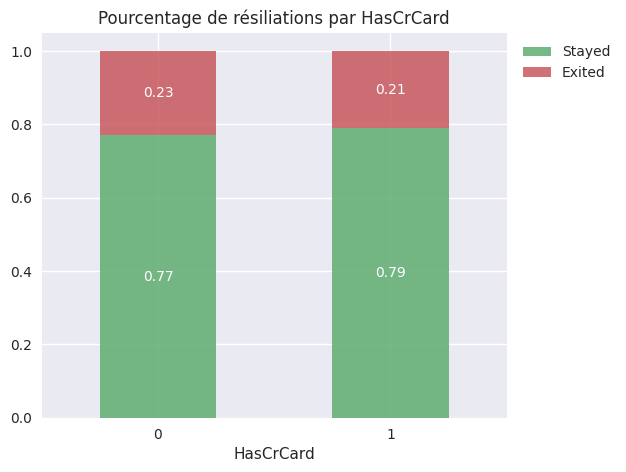

In [34]:
col = "HasCrCard"
analyze_disc_target(col)

- Le taux de churn semble être indépendant du fait que les clients possèdent une carte de crédit.

---

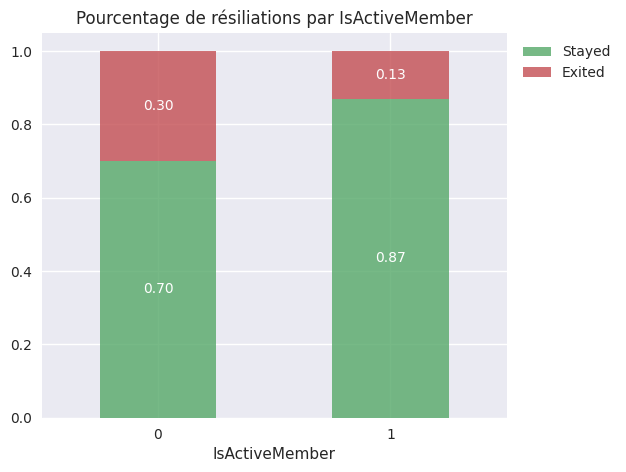

In [35]:
col = "IsActiveMember"
analyze_disc_target(col)

- Les membres actifs sont moins susceptibles de résilier (13%) que les non-actifs (30%).

---

##### **b. Variables continues vs. cible (Exited)**

In [36]:
print(cont)

['CreditScore', 'Age', 'Balance', 'EstimatedSalary']


In [37]:
def analyze_cont_target(col, cont=cont, df=df, target=target, **kwargs):
    if col not in cont:
        print(f"La colonne '{col}' n'est pas une variable continue.")
        return
    
    data_stayed = df.query(f"{target} == 'Stayed'")[col]
    data_exited = df.query(f"{target} == 'Exited'")[col]
    
    colors = sns.color_palette()
    alpha = 0.6
    colors = [colors[1] + (alpha,), colors[2] + (alpha,)]

    fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, height_ratios=[1, 7])
    plt.subplots_adjust(hspace=0.02)

    # Boîte à moustaches
    boxes = axes[0].boxplot(
        [data_stayed, data_exited],
        sym=".",
        orientation="horizontal",
        widths=0.7,
        tick_labels=["", ""],
        patch_artist=True,
        medianprops=dict(color="k"),
        flierprops=dict(markersize=1),
    )
    
    for patch, color in zip(boxes["boxes"], colors):
        patch.set_facecolor(color)
    
    # Histogramme
    axes[1].hist(data_exited, density=True, bins=100, color=colors[1], label="Exited")
    axes[1].hist(data_stayed, density=True, bins=100, color=colors[0], label="Stayed")
    axes[1].set_ylabel("Density")
    axes[1].legend(bbox_to_anchor=(1.25, 1))

    if "xticks" in kwargs:
        axes[1].set_xticks(kwargs["xticks"])
    
    fig.suptitle(kwargs.get("title", f"Distribution de {col} selon la variable cible"))
    plt.show()

---

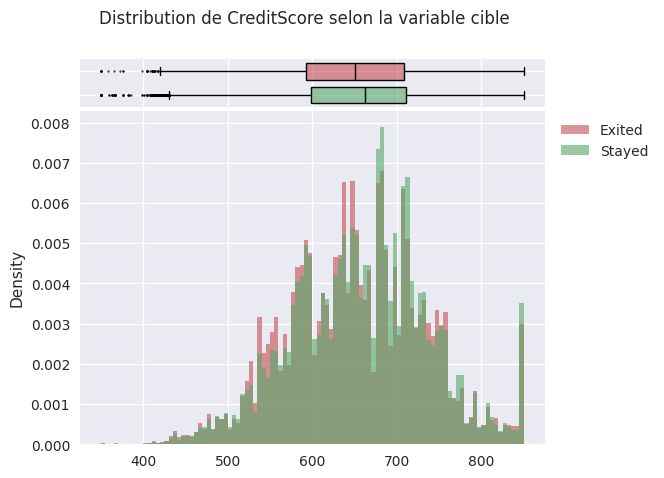

In [38]:
col = "CreditScore"
analyze_cont_target(col)

---

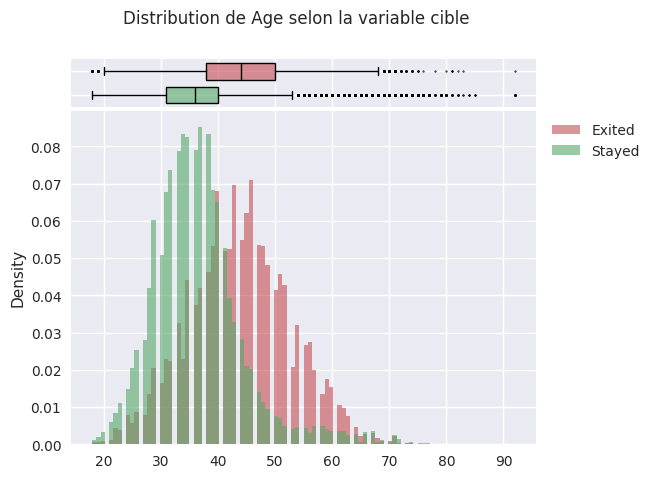

In [39]:
col = "Age"
analyze_cont_target(col)

---

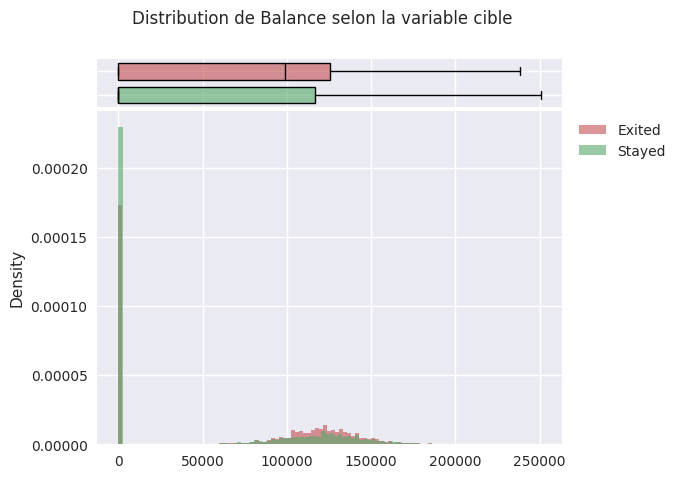

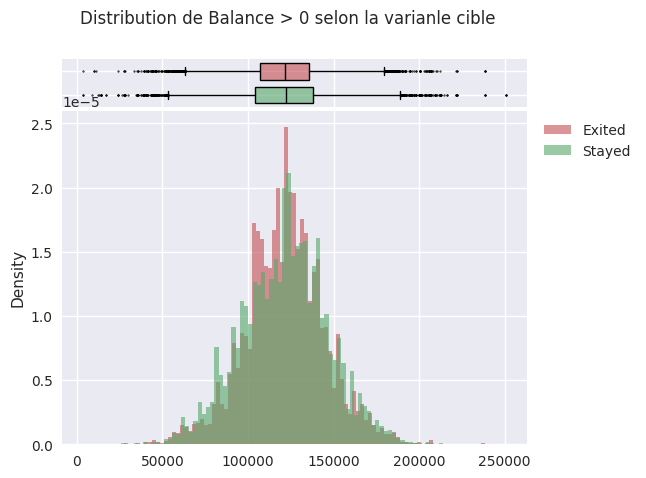

In [40]:
col = "Balance"

analyze_cont_target(col)

analyze_cont_target(
    col,
    df=df.query(f"{col} > 0"),
    title=f"Distribution de {col} > 0 selon la variable cible",
)

---

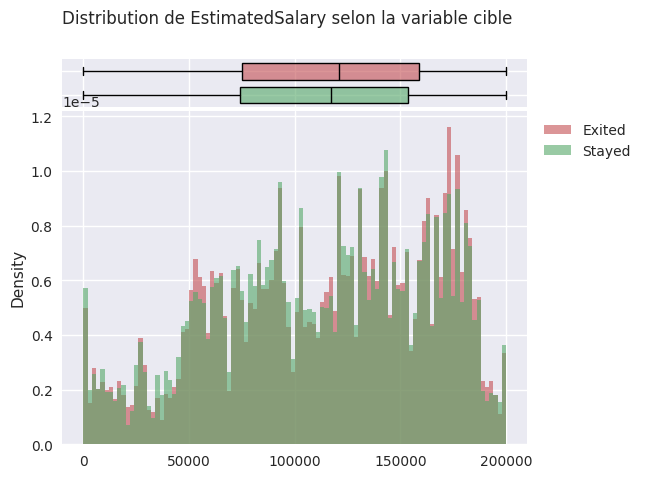

In [41]:
col = "EstimatedSalary"
analyze_cont_target(col, xticks=np.linspace(0, 2e5, 5))

---

- On remarque sur les boîtes à moustache que les clients qui résilient sont légèrement plus jeunes (médiane = 36 ans) que ceux qui ne le restent (médiane = 44 ans), malgré des étendues similaires. 
- Mis à part ce fait, il ne se dégage aucune tendance particulière dans la variation des variables continues en fonction de la variable cible.

##### **c. Autres analyses** 

**1. La France et l'Espagne partagent les mêmes caractéristiques, tandis que les données relatives à l'Allemagne sont significativement différentes.**

---

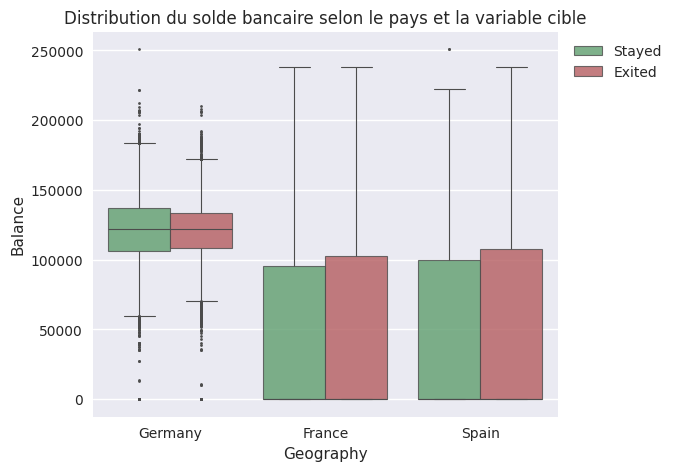

In [42]:
# Exemple 1
colors = sns.color_palette()

plt.figure(figsize=(6, 5))
ax = sns.boxplot(
    data=df,
    x="Geography",
    y="Balance",
    hue="Exited",
    palette={"Stayed": colors[1], "Exited": colors[2]},
    fliersize=1,
    linewidth=0.8,
)

for patch in ax.patches:
    patch.set_alpha(0.8)
    
plt.title("Distribution du solde bancaire selon le pays et la variable cible")
plt.legend(bbox_to_anchor=(1.25, 1))
plt.show()

- Le solde du compte des clients allemands a une valeur médiane avoisinant les 122K€, avec une distribution qui paraît normale.
- Les soldes à 0 sont pour l'écrasante majorité l'affaire des français et des espagnols.

---

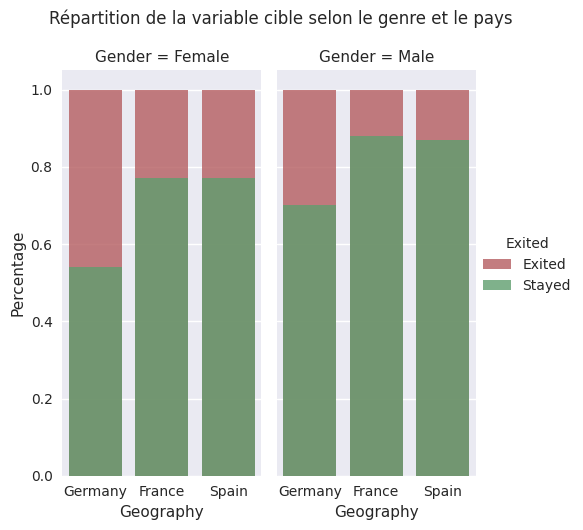

In [43]:
# Exemple 2
tmp_df = (
    df
    .groupby(["Geography", "Gender"])["Exited"]
    .value_counts(normalize=True)
    .round(2)
    .reset_index(name="Percentage")
    .sort_values(
        ["Geography", "Exited"],
        key=lambda x: x.map({"Germany": 1, "France": 2, "Spain": 3}),
        ignore_index=True
    )
)

tmp_df["Percentage_orig"] = tmp_df["Percentage"]
tmp_df.loc[1::2, "Percentage"] = 1

colors = sns.color_palette()

sns.catplot(
    data=tmp_df,
    x="Geography",
    y="Percentage",
    hue="Exited",
    col="Gender",
    kind="bar",
    alpha=0.8,
    dodge=False,
    palette={"Stayed": colors[1], "Exited": colors[2]},
    height=5,
    aspect=0.5,
    hue_order=["Exited", "Stayed"],
)

plt.suptitle("Répartition de la variable cible selon le genre et le pays", y=1.05)
plt.show()

- Que l'on soit chez les hommes ou les femmes, on observe clairement des taux de churn sensiblement égaux pour la France et l'Espgne, tandis que l'Allemagne a ses propres valeurs.

---